In [153]:
# Importing PyTorch
import torch
torch.version.__version__

'2.1.0+cpu'

# Loading training & testing dataset

In [154]:
import pandas as pd  # Import the Pandas library for data manipulation.

# Define the input file name as a variable for easy modification.
input_file = 'output_results.csv'

# Read the CSV data from the specified input file into a Pandas DataFrame.
csv_data = pd.read_csv(input_file)

# Display the first few rows of the DataFrame to inspect the data.
csv_data.head()

,H,B,q,R_int,gamma,Su,sf_lower,sf_upper
0,8,4,10,0.6,18,25,1.041,1.087
1,8,4,10,0.8,18,25,1.044,1.087
2,6,20,20,0.8,18,25,1.045,1.080
3,6,20,20,0.6,18,25,1.047,1.080
4,6,20,20,1.0,18,25,1.048,1.080


# Defining MyDataset class

## 1. Class definition

In [155]:
from torch.utils.data import Dataset
import numpy as np
import math

class MyDataset(Dataset):
    """
    A custom PyTorch dataset for loading data from a CSV file and preparing it for training or testing.

    Args:
        file_name (str): The path to the CSV file containing the dataset.
        train_test_ratio (float, optional): The ratio of the dataset to be used for training (default is 0.9).
        test (bool, optional): If True, the dataset is prepared for testing; otherwise, it's prepared for training (default is False).

    Attributes:
        x_data (torch.Tensor): The input data.
        y_data (torch.Tensor): The target data.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns the input and target data for a specific index.
    """

    def __init__(self, file_name, train_test_ratio=0.9, test=False):
        """
        Initializes the MyDataset with data from a CSV file.

        Args:
            file_name (str): The path to the CSV file containing the dataset.
            train_test_ratio (float, optional): The ratio of the dataset to be used for training (default is 0.9).
            test (bool, optional): If True, the dataset is prepared for testing; otherwise, it's prepared for training (default is False).
        """
        _df = pd.read_csv(file_name)

        if test:
            data_len = math.floor((1 - train_test_ratio) * len(_df.iloc[:, 0]))
        else:
            data_len = math.floor(train_test_ratio * len(_df.iloc[:, 0]))

        x = _df.iloc[:data_len, :-2].values
        y = _df.iloc[:data_len, -2:].values

        self.x_data = torch.tensor(x, dtype=torch.float32)
        self.y_data = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return np.shape(self.y_data)[0]

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

## 2. MyDataset class implementation

In [156]:
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # choose the training and test datasets
    # Create a training dataset from the input CSV file.
    train_data = MyDataset(input_file)

    # Create a testing dataset from the input CSV file.
    test_data = MyDataset(input_file, test=True)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

**Hyperparameters:**

- Number of training epochs: `EPOCH = 10`
- Batch size for mini-batch gradient descent: `BATCH_SIZE = 10`
- Learning rate for the optimization algorithm (e.g., stochastic gradient descent): `LR = 0.001`


In [157]:
# Explanation:
# - PyTorch uses random numbers in various operations, such as weight initialization, data shuffling, and more.
# - By setting the random seed to a specific value (in this case, 1), we ensure that the same random numbers are generated every time we run the code.
# - This is important for reproducibility, which means getting the same results each time you run the code.
# - Reproducibility is crucial in machine learning and deep learning to validate and compare results.

# Note: Setting the random seed to 1 is just an example. You can choose any integer value for reproducibility.
torch.manual_seed(1)  # Reproducible

# Number of training epochs
EPOCH = 100

# Batch size for mini-batch gradient descent
BATCH_SIZE = 36

# Learning rate for the optimization algorithm (e.g., stochastic gradient descent)
LR = 0.001

**Data Loaders and Batch Information:**

- Import the necessary DataLoader module from PyTorch to handle dataset loading.

- Create a data loader for the training dataset with the following parameters:
  - Batch size: `BATCH_SIZE`
  - No shuffle.

- Create a data loader for the test dataset with the same parameters as the training data loader.

- To obtain a single batch of training data and labels, use the `next` function on an iterator created from `train_loader`.

- Display the shape of the feature batch:
  - `train_features.size()` returns the shape (dimensions) of the feature batch.

- Display the shape of the label batch:
  - `train_labels.size()` returns the shape (dimensions) of the label batch.


In [158]:
# from torch.utils.data import DataLoader

# # Create a data loader for the training dataset
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Create a data loader for the test dataset
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Obtain a single batch of training data and labels using the `train_loader`.
# # This is done by using the `next` function on an iterator created from `train_loader`.
# train_features, train_labels = next(iter(train_loader))

# # Print the shape of the feature batch.
# # `train_features.size()` returns the shape (dimensions) of the feature batch.
# print(f"Feature batch shape: {train_features.size()}")

# # Print the shape of the label batch.
# # `train_labels.size()` returns the shape (dimensions) of the label batch.
# print(f"Labels batch shape: {train_labels.size()}")

### Multiple Linear Regression Neural Network

Defines a PyTorch neural network module for multiple linear regression. The neural network consists of three fully connected layers, and the docstring provides a detailed explanation of its structure and usage.

In [159]:
import torch as T
import torch.nn as nn

class MultipleLinearRegression(nn.Module):
    """
    A PyTorch module representing a multiple linear regression neural network.

    This neural network consists of three fully connected layers: hid1, hid2, and oupt.
    The hid1 layer takes the input features and passes them through 6 units with a sigmoid activation.
    The hid2 layer processes the hid1 output through 6 units with a sigmoid activation.
    The oupt layer provides the final output based on the hid2 activations with no activation applied.

    Parameters:
    - input (int): Number of input features. Default is 6.
    - output (int): Number of output units. Default is 2.

    Attributes:
    - hid1 (nn.Linear): First hidden layer with 6 units and a sigmoid activation.
    - hid2 (nn.Linear): Second hidden layer with 6 units and a sigmoid activation.
    - oupt (nn.Linear): Output layer with 'output' units and no activation.

    Methods:
    - forward(x): Defines the forward pass of the neural network.
      Args:
        x (torch.Tensor): Input tensor.
      Returns:
        torch.Tensor: Output tensor.

    Example usage:
    ```
    model = MultipleLinearRegression(input=6, output=2)
    output = model(input_tensor)
    ```
    """

    def __init__(self, input=6, output=2):
        super(MultipleLinearRegression, self).__init__()
        # Define the layers of the neural network.
        # Three fully connected layers are used: hid1, hid2, and oupt.
        self.hid1 = nn.Linear(input, 32)  # Layer with 6 units, input features to 6 units.
        self.hid2 = nn.Linear(32, 8)     # Layer with 6 units, 6 units to 6 units.
        self.oupt = nn.Linear(8, output)  # Output layer, 6 units to 'output' units.

        # Initialize the weights and biases of each layer.
        nn.init.xavier_uniform_(self.hid1.weight)  # Xavier initialization of weights for hid1.
        nn.init.zeros_(self.hid1.bias)            # Initialize biases of hid1 to zeros.
        nn.init.xavier_uniform_(self.hid2.weight)  # Xavier initialization of weights for hid2.
        nn.init.zeros_(self.hid2.bias)            # Initialize biases of hid2 to zeros.
        nn.init.xavier_uniform_(self.oupt.weight)  # Xavier initialization of weights for oupt.
        nn.init.zeros_(self.oupt.bias)            # Initialize biases of oupt to zeros.

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        # Apply the sigmoid activation function to the hidden layers 'hid1' and 'hid2'.
        z = T.sigmoid(self.hid1(x))
        z = T.tanh(self.hid2(z))

        # The output layer 'oupt' does not apply an activation function (linear layer).
        z = self.oupt(z)  # no activation

        return z

### Initialize the Multiple Linear Regression (MLR) Model

An instance of the Multiple Linear Regression (MLR) model is created and its parameters are printed. The MLR model is designed for regression tasks, and in this instance, it is configured with 6 input features and is expected to produce 2 output values.


In [160]:
# Create an instance of the MultipleLinearRegression model with 6 input features and 2 output units.
MLR_model = MultipleLinearRegression(input=6, output=2)

# Print the parameters of the MLR model.
print("The parameters: ", list(MLR_model.parameters()))

The parameters:  [Parameter containing:
tensor([[-0.1680, -0.3519,  0.2442, -0.0910, -0.2507,  0.1035],
        [-0.2971,  0.2781,  0.2285, -0.3905, -0.3119, -0.2620],
        [-0.2151,  0.0496, -0.3929, -0.2946,  0.1815, -0.1301],
        [-0.1581, -0.3287,  0.1611,  0.0281, -0.1536, -0.2433],
        [ 0.0845,  0.1081,  0.1764,  0.1181, -0.0606, -0.3076],
        [ 0.2530, -0.0034, -0.2641,  0.3427,  0.2215, -0.3123],
        [-0.1984, -0.1352, -0.2294,  0.1856, -0.2835,  0.3693],
        [-0.1642,  0.2346,  0.0135, -0.1748,  0.2653, -0.3032],
        [-0.2102,  0.0476,  0.3152, -0.1703, -0.2420, -0.2537],
        [-0.1752, -0.1373, -0.0926, -0.2261,  0.1242,  0.0032],
        [-0.2596, -0.2269,  0.0841, -0.0057,  0.2812, -0.0602],
        [-0.3219, -0.2939, -0.1166, -0.0880,  0.0453, -0.0891],
        [ 0.1466, -0.1322,  0.2916,  0.0913, -0.1222,  0.3541],
        [ 0.1014, -0.2700, -0.2211,  0.2492,  0.1815,  0.3103],
        [-0.0305,  0.2779,  0.1976,  0.1229, -0.0920,  0.3831],


# Model Optimization and Loss Definition

In this section, the model optimizer is selected, and the loss criterion for training the Multiple Linear Regression model is defined.

## Model Optimizer
We use the AdamW optimizer to update the model parameters during training. The learning rate (LR) determines the step size for parameter updates.

In [161]:
optimizer = torch.optim.AdamW(MLR_model.parameters(), lr=LR)

In [162]:
# Define the Mean Squared Error (MSE) loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Model Prediction Check (Before Training)

In this section, we check the model's ability to make predictions before any training has occurred. This is often referred to as a "sanity check" to ensure the model is functional.

## Model Prediction
We provide a sample input tensor `x` to the Multiple Linear Regression (MLR) model and evaluate its prediction. Please note that at this stage, the model has not undergone any training.


In [163]:
# Check the model gives data (NO TRAINING YET)
x = torch.tensor([8, 6, 10, 1.0, 16, 100])
y_pred = MLR_model(x)
print(y_pred)

tensor([-0.4603, -0.9805], grad_fn=<ViewBackward0>)


# Model Training Loop

In this section, we define the training loop for the Multiple Linear Regression (MLR) model. The training process involves multiple epochs, where the model learns from the training data to optimize its parameters and reduce the loss.

In [164]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [165]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping()
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(train_loss, valid_loss)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    return  model, avg_train_losses, avg_valid_losses

In [166]:
# t_losses = []
# for epoch in range(EPOCH):
#     for i, (inputs, targets) in enumerate(train_loader):
#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = MLR_model(inputs)
#         loss = criterion(outputs, targets)
#         t_losses.append(loss.item())

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#         # scheduler.step()

#         # Print training statistics
#         if (i + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{EPOCH}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


In [167]:
train_loader, test_loader, valid_loader = create_datasets(BATCH_SIZE)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(MLR_model, BATCH_SIZE, patience, EPOCH)

[  1/100] train_loss: 1.78754 valid_loss: 1.72133
[  2/100] train_loss: 1.74935 valid_loss: 1.69665
[  3/100] train_loss: 1.72302 valid_loss: 1.68804
[  4/100] train_loss: 1.71946 valid_loss: 1.68806
[  5/100] train_loss: 1.72925 valid_loss: 1.68919
[  6/100] train_loss: 1.74269 valid_loss: 1.68840
[  7/100] train_loss: 1.72800 valid_loss: 1.68609
[  8/100] train_loss: 1.71601 valid_loss: 1.68406
[  9/100] train_loss: 1.72265 valid_loss: 1.68310
[ 10/100] train_loss: 1.72215 valid_loss: 1.68281
[ 11/100] train_loss: 1.72727 valid_loss: 1.68245
[ 12/100] train_loss: 1.72199 valid_loss: 1.68196
[ 13/100] train_loss: 1.70435 valid_loss: 1.68154
[ 14/100] train_loss: 1.71884 valid_loss: 1.68135
[ 15/100] train_loss: 1.71640 valid_loss: 1.68134
[ 16/100] train_loss: 1.71495 valid_loss: 1.68131
[ 17/100] train_loss: 1.72780 valid_loss: 1.68115
[ 18/100] train_loss: 1.70933 valid_loss: 1.68090
[ 19/100] train_loss: 1.73092 valid_loss: 1.68074
[ 20/100] train_loss: 1.72749 valid_loss: 1.68069


# Model Evaluation on Test Data

In this section, we evaluate the trained MLR model on the test dataset and calculate the test loss to assess the model's performance.

In [168]:
# # Evaluate the model on the test data
# with torch.no_grad():
#     total_loss = 0
    
#     # Iterate over batches in the test loader
#     for inputs, targets in test_loader:
#         outputs = MLR_model(inputs)  # Forward pass to get model predictions
#         loss = criterion(outputs, targets)  # Calculate the loss
        
#         total_loss += loss.item()  # Accumulate the loss for all batches
    
#     mean_loss = total_loss / len(test_loader)  # Calculate the mean loss over all batches
#     print(f'Test Loss: {mean_loss:.4f}')

# Plotting Training Losses

In this section, we visualize the training progress by plotting the training losses. The loss values are plotted against the number of iterations, providing insight into the model's convergence during training.

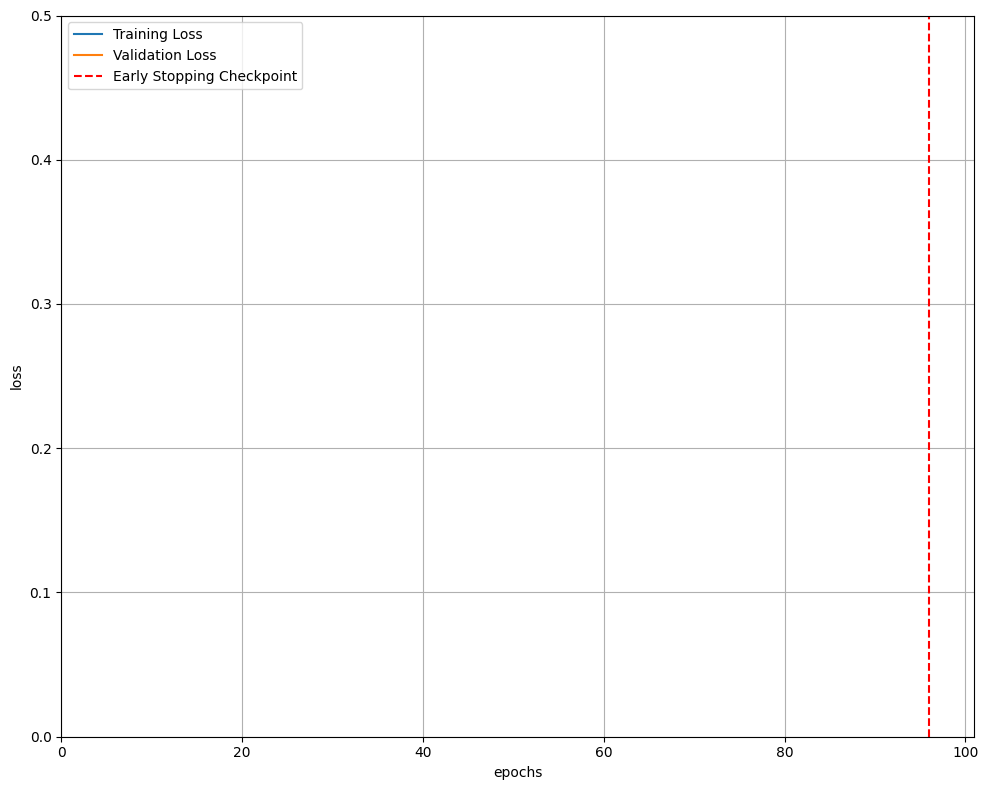

In [169]:
# visualize the loss as the network trained
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Testing the Model

In this section, we evaluate the trained model by testing it on a set of case histories. The case histories include parameters and known outcomes for different locations.

## Case Histories Parameters
We define a list of case histories parameters, where each sub-list represents a location's specific parameters:

```python
cases = [
    [2.4, 4.8, 15, 1, 19, 12],   # Fornebu, Oslo
    [5, 5, 0, 1, 19, 16],       # Feria, Oslo
    [11.3, 16, 0, 1, 19, 35]    # Chicago, USA
]


In [170]:
# Testing the model

# Case histories parameters
# Input is on the form [B (m), H (m), q (kPa), Rint, Gamma (kN/cu.m), Su (kPa)]

cases = [
    [2.4, 4.8, 15, 1, 19, 12],  # Fornebu, Oslo
    [5, 5, 0, 1, 19, 16],      # Feria, Oslo
    [11.3, 16, 0, 1, 19, 35]   # Chicago, USA
]


# Case histories outcomes
cases_op = [
    [1.03, 1.11, 0.97, 1.05],  # Fornebu, Oslo
    [1.02, 1.26, 1.03, 1.1],  # Feria, Oslo
    [1, 1.11, 0.95, 1]        # Chicago, USA
]

for i, each_case in enumerate(cases):
    y_pred_MLR = MLR_model(torch.Tensor(each_case))
    val = float(np.average(y_pred_MLR.detach()))
    cases_op[i].append(val)
    print(f'Avg. FoS for case_{i} is {val}')

Avg. FoS for case_0 is -0.9112091064453125
Avg. FoS for case_1 is -0.968427836894989
Avg. FoS for case_2 is -1.016046404838562


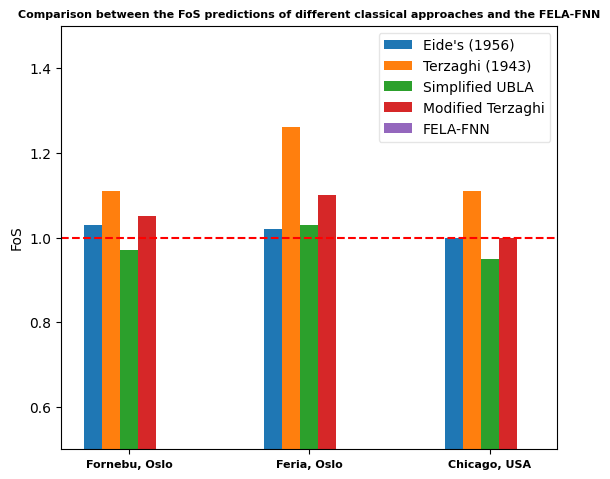

In [171]:
import numpy as np
import matplotlib.pyplot as plt

species = ('Fornebu, Oslo', 'Feria, Oslo', 'Chicago, USA')

means = {
    "Eide's (1956)": [],
    "Terzaghi (1943)": [],
    "Simplified UBLA": [],
    "Modified Terzaghi": [],
    "FELA-FNN": []
}

# Assuming you have 'cases_op' defined elsewhere

for i, items in enumerate(means.items()):
    means[items[0]] += ([x[i] for x in cases_op])

x = np.arange(len(species))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(6.4, 5.5))

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('FoS')

# Set y-axis limits
ax.set_ylim(0.5,1.5)

# Adjust the x-axis tick positions and labels
new_x = x + width * (len(means) - 1) / 2
ax.set_xticks(new_x)
ax.set_xticklabels(species, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust 'ha' to 'center'

# Adjust the legend location to 'upper right' and specify the number of columns (ncols)
legend = ax.legend(loc='upper right', ncols=1)

# Set the transparency of the legend background to 50%
legend.get_frame().set_alpha(0.5)

ax.axhline(y=1, color='red', linestyle='--', label='Y = 1')

# Set the chart title with a customizable font size
chart_title = "Comparison between the FoS predictions of different classical approaches and the FELA-FNN"
title_fontsize = 8  # You can adjust the font size as needed
ax.set_title(chart_title, fontsize=title_fontsize, fontweight='bold')  # Make the title bold

# Increase figure quality by adjusting the DPI
plt.savefig('your_figure_600_2.png', dpi=600)  # You can adjust the filename and DPI as needed

plt.show()

## Plotting Su vs. FoS

In [172]:
''' 
    B:      Excavation width (m)
    H:      Excavation height (m)
    q:      Uniform surcharge at GS (kPa)
    Rint:   Interface strength reduction factor
    Gamma:  Soil unit weight (kN/cu.m)
    Su:     Undrained shear strength (kPa)
    
case_input = [B (m), H (m), q (kPa), Rint, Gamma (kN/cu.m), Su (kPa)]
y_pred_MLR = MLR_model(torch.Tensor(each_case))
LB_FoS = float(np.min(y_pred_MLR.detach()))
UB_FoS = float(np.max(y_pred_MLR.detach()))

'''
no_of_curve_points = 50
B = 5
H = 10
q = 20
Rint = 1
Gamma = 19
su = range(0, no_of_curve_points, 1)  # Changed the step size to 1

cases = []
for i in su:
    cases.append([B, H, q, Rint, Gamma, i])

for each_case in cases:
    y_pred_MLR = MLR_model(torch.Tensor(each_case))    
    LB_FoS = float(np.min(y_pred_MLR.detach()))
    print('LB FoS: ', LB_FoS)
    UB_FoS = float(np.min(y_pred_MLR.detach()))
    print('UB FoS: ',UB_FoS)
    Avg_FoS = float(np.average(y_pred_MLR.detach()))
    print(Avg_FoS)
    

TypeError: min() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


In [ ]:
#cases
print('Nahh')

In [ ]:
''' 
    B:      Excavation width (m)
    H:      Excavation height (m)
    q:      Uniform surcharge at GS (kPa)
    Rint:   Interface strength reduction factor
    Gamma:  Soil unit weight (kN/cu.m)
    Su:     Undrained shear strength (kPa)
    
case_input = [B (m), H (m), q (kPa), Rint, Gamma (kN/cu.m), Su (kPa)]
'''

no_of_curve_points = 50
B = 5
H = 10
q = 20
Rint = 1
Gamma = 19
su = range(0, no_of_curve_points, 1)  # Changed the step size to 1

cases = []
for i in su:
    cases.append([B, H, q, Rint, Gamma, i])

for each_case in cases:
    y_pred_MLR = MLR_model(torch.Tensor(each_case))    
    print(float(min(y_pred_MLR.detach())))
    Avg_FoS = float(np.average(y_pred_MLR.detach()))
    print('Avg FoS: ', Avg_FoS)  # Print the average factor of safety